# Open System Time Evolution Benchmark

This benchmark evaluates the performance and accuracy of **Basis-Update and Galerkin (BUG) Algorithms** for simulating **Markovian open quantum systems** governed by the **Lindblad master equation** in Liouville Space.

```
d|ρ⟩⟩/dt = -i ℒ |ρ⟩⟩
```
where ℒ is the **Lindbladian superoperator**:
```
ℒ = H ⊗ I - I ⊗ H^T + Σₖ (Lₖ ⊗ L̄ₖ - ½(Lₖ†Lₖ ⊗ I + I ⊗ L̄ₖ†L̄ₖ))
```

- **vectorized Density matrices** are represented by **Tree Tensor Network Density Operators (TTNDOs)** where
each physical site has dual representation with `_bra` and `_ket` indices

## **BUG** (Basis-Update and Galerkin) Algorithms :

#### **PRBUG** - Parallel Recursive BUG
- PRBUG algorithm for time evolution of 
    tree tensor network state, originally introduced in https://www.doi.org/10.1137/22M1473790.
- This algorithm process the tree tensor network recursively from the root node to the leaves.
- At each stage, sibling nodes are update independently, thus they can be processed in parallel.
- Recursive truncation is performed after each time step to keep the bond dimensions manageable.
- Note : Current implementaion has not yet develpoed for parallelization in node updating.

#### **FPBUG** - First-order Path BUG
- FPBUG (First-order Path Basis-Update and Galerkin) algorithm for time evolution of tree tensor network state.
- This algorithm performs BUG by sweeping through the network, thus nodes are updated on a path similar to TDVP algorithm on TTN introduced in https://scipost.org/SciPostPhys.8.2.024/pdf
- Therefore, node updatings are not parallelizable, however nodes are updated with environemnt that are built form the more (compared to PRBUG) recently updated eenvironment of their sibling branches.
- No basis change tensor chacing is required (compared to PRBUG).
- This algorithm is more straighforward and more compatible to MPS/MPO framework. 

#### **SPBUG** - Second-order Path BUG
- This algorithm performs FPBUG with half time-step at each iteration in backward and forward sweeps. 

## **TNDO Structures**
This benchmark evaluates **4 distinct TTNDO structures**:

1. Symmetric MPS TTNDO
- Star-like structure where central root node has two children.
- All physical sites connect to central root

2. Intertwined MPS TTNDO
- Linear MPS chain with bra-ket alternation : `|site1_ket⟩ - |site1_bra⟩ - |site2_ket⟩ - |site2_bra⟩ - ...`

3. Binary Tree TTNDO
- Binary tree with depth log₂(N), 
- Physical nodes are on the leaves and the parents of the leaves

4. Cayley Tree TTNDO
- Cayley graph structure
- Physical nodes are on the leaves

## **Physical System: 1D Transverse Field Ising Model**
```
H = -J Σᵢ (σˣᵢ σˣᵢ₊₁) - h Σᵢ σᶻᵢ
```
- **Nearest-neighbor coupling**: J = 1.0 (XX interactions)  
- **External magnetic field**: h = 0.5 (Z-direction)
- **Chain length**: 10 spins (qubits)

### Open System Dynamics: Lindblad Master Equation
```
dρ/dt = -i[H, ρ] + Σᵢ 𝒟[L⁻ᵢ](ρ) + Σᵢ 𝒟[Lᶻᵢ](ρ)
```
where 𝒟[L](ρ) = γ(LρL† - ½{L†L, ρ}) and:
- **L⁻ᵢ = σ⁻ᵢ**: Lowering operator (amplitude damping)
- **Lᶻᵢ = σᶻᵢ**: Dephasing operator (pure dephasing)
- **Decoherence rates**: γ = γφ = 0.1

### Superoperator Implementation
`generate_lindbladian()` converts this to superoperator form using :
1. **Hamiltonian terms**: H ⊗ I - I ⊗ H^T (unitary evolution)
2. **Jump operator terms**: Lₖ ⊗ L̄ₖ (quantum jumps)  
3. **Anti-commutator terms**: -½(Lₖ†Lₖ ⊗ I + I ⊗ L̄ₖ†L̄ₖ) (normalization)


### Local Time Evolution Settings
- **Integration method**: Runge-Kutta 45 (RK45) with adaptive stepping
- **Tolerances**: atol = rtol = 1×10⁻⁶

## **Benchmark Parameters**

### Time Evolution Settings
- **Final time**: T = 10.0
- **Base time steps**: Δt = 0.4 ---> 4 levels (Δt, Δt/2, Δt/4, Δt/8)

### Initial Conditions
- **Initial state**: |0⟩⊗ᴺ (all spins down)
- **Initial bond dimension**: 6

### Observables
1. **Average magnetization**: ⟨M⟩ = (1/N) Σᵢ ⟨σᶻᵢ⟩
2. **Total energy**: ⟨H⟩
3. **Trace norm**: Tr(ρ)

### Errors
- **Magnetization error**: |⟨M⟩_TTN - ⟨M⟩_exact|
- **Energy error**: |⟨H⟩_TTN - ⟨H⟩_exact|  
- **Norm deviation**: |Tr(ρ) - 1|

### Error function modes : 
- **FINAL**: Error at final time T
- **MEAN**: Time-averaged error over simulation
- **ACCUMULATED**: Cumulative error over time

### Exact solution : 
- All errors are computed relative to **exact QuTiP solutions**:
- For this simulation, and with consumer-grade cpu, qutip is able to go upto 11 qubits and also 12 qubits are possible if we use complex64 for all entries.

# Library Imports

In [ ]:
# System and utility imports
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

import math
from enum import Enum
from warnings import warn
from typing import Optional, List, Tuple
from collections import defaultdict

# Scientific computing libraries
import matplotlib.pyplot as plt
import numpy as np

# PyTreeNet core modules
from pytreenet.time_evolution.time_evo_enum import TimeEvoAlg
from pytreenet.time_evolution.time_evolution import TimeEvoMode, TimeEvoMethod
from pytreenet.util.tensor_splitting import SVDParameters

# Benchmark-specific modules
from experiments.time_evolution.open_system_bug.sim_script import (SimulationParameters,
                                                                    TimeEvolutionParameters,
                                                                    TTNStructure)
from benchmark_supervisor import (run_benchmarks, load_filtered_results, BenchmarkResultLoader)

# **Benchmark 1**

### In this section we investigate : 

- **TTNDO structure**: How errors scale with different tree structures
- **Trunbcation Threshold**: How errors scale by incresing trucation accuracy
- **Time step dependence**: Error behavior with different time discretization
- **Algorithm comparison**: Relative accuracy between methods

## Setup benchmarck 

In [ ]:
# Setup benchmark directory for result caching
benchmark_dir = os.path.join(os.getcwd(), "banchmark_cache")

# ========================================
# PHYSICAL SYSTEM PARAMETERS
# ========================================

# System size: Number of spins in the 1D chain
length = 10

# Transverse Field Ising Model parameters
ext_magn = 0.5      # External magnetic field strength in z-direction (h)
coupling = 1.0      # Nearest-neighbor coupling strength for XX interactions (J)

# Open system (Lindblad) parameters
relaxation_rate = 0.1   # Local amplitude damping (γ)
dephasing_rate = 0.1    # Local dephasing (γ_φ)

# ========================================
# TIME EVOLUTION PARAMETERS
# ========================================

# Time discretization settings
final_time = 10         # Total simulation time
time_step = 0.4         # Base time step size (will be varied for convergence analysis)
evaluation_time = 2     # Base time interval between observable evaluations

# Initial quantum state parameters
init_bond_dim = 6       # Initial bond dimension for tensor decomposition

# Local time evolution algorithm configuration
# Using Runge-Kutta 45 (adaptive step size) with strict tolerances
time_evo_modes = [TimeEvoMode(TimeEvoMethod.RK45, {'atol': 1e-6, 'rtol': 1e-6})]

# ========================================
# Generate parameters
# ========================================

def generate_timestep_evaluation_grid(time_step: float, evaluation_time: float, levels: int) -> List[Tuple[float, float]]:
    """
    Generate a grid of (time_step, evaluation_time) pairs for convergence analysis.
    
    The function creates pairs where time_step decreases and evaluation_time increases
    by factors of 2, keeping their product constant. This allows studying convergence
    behavior while maintaining the same number of total time steps.
    
    Args:
        time_step: Base time step size
        evaluation_time: Base evaluation time interval
        levels: Number of refinement levels to generate
        
    Returns:
        List of (time_step, evaluation_time) tuples
        
    Example:
        generate_timestep_evaluation_grid(0.4, 2, 3) returns:
        [(0.4, 2), (0.2, 4), (0.1, 8)]
    """
    if levels <= 0:
        raise ValueError("levels must be positive")
    grid = []
    for k in range(levels):
        ts = time_step / (2.0 ** k)
        et = evaluation_time * (2.0 ** k)
        assert ts * et == time_step * evaluation_time, "Product of timestep and evaluation time must remain constant"
        grid.append((ts, int(et)))
    return grid

def generate_parameters_1(experiment_label: str,
                        ttn_structure: TTNStructure,
                        max_product_dim_list: List[int],
                        ts_levels: int = 3,
                        depth: Optional[int] = None,
                        svd_params: SVDParameters = SVDParameters()) -> list:
    """    
    This function creates all combinations of:
    - Time evolution algorithms (PRBUG, FPBUG, SPBUG)
    - Time step levels (for convergence analysis)
    - Maximum product dimensions
    
    Args:
        experiment_label: Identifier for this experiment series
        ttn_structure: Tree tensor network structure (MPS, BINARY, SYMMETRIC, etc.)
        max_product_dim_list: List of maximum product dimensions to test
        ts_levels: Number of time step refinement levels
        depth: Tree depth (auto-calculated if None)
        svd_params: Base SVD parameters (max_product_dim will be overridden)

    Returns:
        List of (SimulationParameters, TimeEvolutionParameters) tuples
    """
    evo_algs = [TimeEvoAlg.PRBUG,
                TimeEvoAlg.FPBUG,
                TimeEvoAlg.SPBUG]

    # Generate time step grid for convergence analysis
    timestep_evaluation = generate_timestep_evaluation_grid(time_step,
                                                            evaluation_time,
                                                            ts_levels)

    # Validate and set tree depth based on structure type
    if ttn_structure == TTNStructure.SYMMETRIC_MPS and depth != 0 or depth is None:
        warn("Invalid depth for Symmetric MPS, setting depth to 0")
        depth = 0
    elif ttn_structure == TTNStructure.INTERTWINED_MPS and depth != 0 or depth is None:
        warn("Invalid depth for Intertwined MPS, setting depth to 0")
        depth = 0
    elif depth is None and ttn_structure != TTNStructure.INTERTWINED_MPS or ttn_structure != TTNStructure.SYMMETRIC_MPS:
        depth = max(1, math.ceil(math.log2(length)))
        print(f"Depth not specified, using maximum depth: {depth}")

    # Extract SVD parameters (max_product_dim will be systematically varied)
    maximum_bond_dim = svd_params.max_bond_dim
    rel_svalue = svd_params.rel_tol
    abs_svalue = svd_params.total_tol
    renorm = svd_params.renorm
    sum_trunc = svd_params.sum_trunc
    sum_renorm = svd_params.sum_renorm

    # Generate all parameter combinations
    complete_params_list = []

    for time_evo_mode in time_evo_modes:
        for evo_alg in evo_algs:
            for max_prod_dim in max_product_dim_list:
                for ts, ev_time in timestep_evaluation:
                    # Physical system parameters
                    sim_params = SimulationParameters(experiment_label,
                                                    ttn_structure,
                                                    length,
                                                    coupling,
                                                    ext_magn,
                                                    relaxation_rate,
                                                    dephasing_rate,
                                                    init_bond_dim,
                                                    depth)

                    # Time evolution algorithm parameters
                    time_evo_params = TimeEvolutionParameters(time_evo_mode,
                                                            evo_alg,
                                                            ts,
                                                            ev_time,
                                                            final_time,
                                                            max_bond_dim=maximum_bond_dim,
                                                            max_product_dim=max_prod_dim,
                                                            rel_svalue=rel_svalue,
                                                            abs_svalue=abs_svalue,
                                                            renorm=renorm,
                                                            sum_trunc=sum_trunc,
                                                            sum_renorm=sum_renorm)
                    complete_params_list.append((sim_params, time_evo_params))

    return complete_params_list


In [ ]:
# ========================================
# Plot functions
# ========================================

class PlotMode(Enum):
        FINAL = "final"
        MEAN = "mean"
        ACCUMULATED = "accumulated"

class DataType(Enum):
    MAGNETIZATION = "magnetization"
    ENERGY = "energy" 
    NORM = "norm"

def _load_and_process_benchmark_data(filter_criteria, plot_mode: PlotMode):
    """
    Helper function to load and process benchmark data for advanced plotting with CPU time.
    
    Args:
        filter_criteria: Dict to filter results
        plot_mode: PlotMode enum specifying how to compute error metrics
    
    Returns:
        tuple: (groups, all_structures, all_algorithms) where groups contains processed simulation data
    """
    # Load filtered results
    filtered_results = load_filtered_results(filter_criteria, benchmark_dir)

    if not filtered_results:
        print(f"❌ No results found for criteria: {filter_criteria}")
        return None, None, None

    print(f"📊 Found {len(filtered_results)} results matching criteria: {filter_criteria}")

    # Group results by (algorithm, structure)
    groups = defaultdict(list)
    loader = BenchmarkResultLoader(benchmark_dir)


    for params, results in filtered_results:
        algorithm = params.get('time_evo_algorithm', 'unknown')
        structure = params.get('ttns_structure', 'unknown')
        group_key = (algorithm, structure)

        # Load error arrays for this result
        param_hash = params['benchmark_hash']
        try:
            mag_error, energy_error = loader.load_error_arrays(param_hash)

            # Get time array and norm data
            times = results.results.get('times', None)
            norm = results.results.get('norm', results.results.get('Identity', None))
            
            # Get CPU time from benchmark metadata (elapsed_time)
            cpu_time = params.get('elapsed_time', 0)
            if cpu_time == 0:
                # Fallback: try to parse from CPU_time string in results if available
                cpu_time_str = results.results.get('CPU_time', '0s')
                if isinstance(cpu_time_str, str) and 's' in cpu_time_str:
                    try:
                        cpu_time = float(cpu_time_str.replace('s', ''))
                    except ValueError:
                        cpu_time = 0

            if times is not None and norm is not None:
                # Calculate norm deviation
                norm_error = abs(norm - 1)

                # Compute error metrics based on plot mode
                energy_metric = 0
                mag_metric = 0
                norm_metric = 0
                
                if plot_mode == PlotMode.FINAL:
                    # Get final error values (last element of each array)
                    energy_metric = energy_error[-1] if len(energy_error) > 0 else 0
                    mag_metric = mag_error[-1] if len(mag_error) > 0 else 0
                    norm_metric = norm_error[-1] if len(norm_error) > 0 else 0
                elif plot_mode == PlotMode.MEAN:
                    # Get mean error values across time
                    energy_metric = energy_error.mean() if len(energy_error) > 0 else 0
                    mag_metric = mag_error.mean() if len(mag_error) > 0 else 0
                    norm_metric = norm_error.mean() if len(norm_error) > 0 else 0
                elif plot_mode == PlotMode.ACCUMULATED:
                    # Get cumulative (sum) error values across time
                    energy_metric = energy_error.sum() if len(energy_error) > 0 else 0
                    mag_metric = mag_error.sum() if len(mag_error) > 0 else 0
                    norm_metric = norm_error.sum() if len(norm_error) > 0 else 0

                # Store data for this simulation
                sim_data = {
                    'params': params,
                    'algorithm': algorithm,
                    'structure': structure,
                    'max_product_dim': params.get('max_product_dim', 0),
                    'cpu_time': cpu_time,
                    'energy_error': energy_metric,
                    'mag_error': mag_metric,
                    'norm_error': norm_metric
                }
                groups[group_key].append(sim_data)
        except (ValueError, KeyError, OSError) as e:
            print(f"⚠️ Could not load error arrays for {param_hash[:12]}: {e}")
            continue

    if not groups:
        print("❌ No valid data found after loading error arrays")
        return None, None, None

    return groups

def plot_benchmark_1(filter_criteria,
                          data_type: DataType = DataType.MAGNETIZATION,
                          plot_mode: PlotMode = PlotMode.FINAL,
                          save_path=None, 
                          figsize=(20, 8)):
    """
    Args:
        filter_criteria: Dict to filter results
        data_type: DataType enum specifying which error type to plot (MAGNETIZATION, ENERGY, or NORM)
        plot_mode: PlotMode enum specifying how to compute error metrics
        save_path: Optional path to save the plot
        figsize: Figure size (width, height)
    """
    groups = _load_and_process_benchmark_data(filter_criteria, plot_mode)
    
    if groups is None:
        return None

    # Map data type to error key and display name
    data_type_mapping = {
        DataType.MAGNETIZATION: {'key': 'mag_error', 'name': 'Magnetization'},
        DataType.ENERGY: {'key': 'energy_error', 'name': 'Energy'},
        DataType.NORM: {'key': 'norm_error', 'name': 'Norm'}
    }
    
    error_key = data_type_mapping[data_type]['key']
    error_name = data_type_mapping[data_type]['name']

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Gather all max_product_dim values and time steps
    all_time_steps = {sim['params'].get('time_step_size', 0) for sims in groups.values() for sim in sims}
    sorted_time_steps = sorted(all_time_steps)
    
    # COLOR SCHEMES for max_product_dim and algorithms
    max_prod_dim_colors = {}
    
    # Define color schemes for each TTNO structure (avoiding algorithm colors)
    structure_color_schemes = {
        'intertwined_mps': {'base_color': (0.8, 0.0, 0.8), 'name': 'Magenta'},    # Dark magenta to pale magenta
        'binary': {'base_color': (0.0, 0.8, 0.8), 'name': 'Cyan'},               # Dark cyan to pale cyan  
        'symmetric_mps': {'base_color': (0.8, 0.6, 0.0), 'name': 'Yellow'},      # Dark yellow to pale yellow
        'mps': {'base_color': (0.4, 0.2, 0.0), 'name': 'Brown'},                 # Dark brown to pale brown
    }
    
    # First, collect max_product_dims per structure
    structure_max_prod_dims = defaultdict(set)
    for (algorithm, structure), sims in groups.items():
        for sim in sims:
            structure_max_prod_dims[structure].add(sim['max_product_dim'])
    
    # Create separate color progressions for each structure
    for structure, max_prod_dims in structure_max_prod_dims.items():
        sorted_dims_for_structure = sorted(max_prod_dims)
        
        # Get the base color for this structure (default to gray if unknown)
        if structure.lower() in structure_color_schemes:
            base_r, base_g, base_b = structure_color_schemes[structure.lower()]['base_color']
        else:
            base_r, base_g, base_b = (0.5, 0.5, 0.5)  # Gray fallback
        
        for i, dim in enumerate(sorted_dims_for_structure):
            if len(sorted_dims_for_structure) == 1:
                # Single value: use the base color at medium intensity
                color_r, color_g, color_b = base_r, base_g, base_b
            else:
                # Multiple values: Create proper dark-to-pale progression
                fade_factor = (len(sorted_dims_for_structure) - 1 - i) / (len(sorted_dims_for_structure) - 1)  # 1.0 to 0.0 (reversed)
                
                # Interpolate between pale color (light) and base color (dark)
                pale_r = base_r + (1.0 - base_r) * 0.7
                pale_g = base_g + (1.0 - base_g) * 0.7  
                pale_b = base_b + (1.0 - base_b) * 0.7
                
                # Interpolate from pale to dark (fade_factor: 1.0=pale, 0.0=dark)
                color_r = pale_r + (base_r - pale_r) * (1.0 - fade_factor)
                color_g = pale_g + (base_g - pale_g) * (1.0 - fade_factor)
                color_b = pale_b + (base_b - pale_b) * (1.0 - fade_factor)
            
            max_prod_dim_colors[dim] = (color_r, color_g, color_b)
    
    # Algorithms: Use green/blue/red colors
    algorithm_base_colors = {
        'prbug': '#00AA00', 'fpbug': '#0066CC', 
        'spbug': '#CC0000'
    }
    
    # Style maps - Fixed to include all TTNDO structure names
    structure_linestyles = {
        'intertwined_mps': '-',      # Solid line
        'binary': '--',              # Dashed line  
        'symmetric_mps': ':',        # Dotted line
        'cayley': '-.',              # Dash-dot line
        'mps': '-'                   # Solid line (fallback)
    }
    
    plotted_structures, plotted_max_prod_dims, plotted_algorithms = set(), set(), set()
    
    # Use wider spacing for time steps to create more space for shaded regions
    timestep_positions = {}
    for i, ts in enumerate(sorted_time_steps):
        timestep_positions[ts] = i * 3  # Use wider spacing: 0, 2, 4, 6... instead of 0, 1, 2...
    
    # Collect all unique (algorithm, structure) combinations per time step for sequential positioning
    timestep_combinations = defaultdict(set)
    for (algorithm, structure), sims in groups.items():
        for sim in sims:
            time_step = sim['params'].get('time_step_size', 0)
            timestep_combinations[time_step].add((algorithm, structure))
    
    # Create sequential positions within each time step range
    offset_step = 0.16  # Larger step for better separation between lines
    range_width = 1.8   # Wider range for each time step to accommodate more separation
    
    # Helper function to plot data on a given axis
    def plot_on_axis(ax, y_data_key, ylabel, title_suffix):
        for (algorithm, structure), sims in groups.items():
            linestyle = structure_linestyles.get(structure.lower(), '-')
            base_color = algorithm_base_colors.get(algorithm.lower(), '#000000')
            
            # Group simulations by time step (no connections between different time steps)
            sims_by_timestep = defaultdict(list)
            for sim in sims:
                time_step = sim['params'].get('time_step_size', 0)
                sims_by_timestep[time_step].append(sim)
            
            # Plot each time step group separately
            for time_step, time_step_sims in sims_by_timestep.items():
                sims_sorted = sorted(time_step_sims, key=lambda x: x['max_product_dim'])
                
                # Get sequential position for this (algorithm, structure) combination within this time step
                combinations_in_timestep = sorted(timestep_combinations[time_step])
                combo_index = combinations_in_timestep.index((algorithm, structure))
                
                # Position starting from the beginning of the range
                base_position = timestep_positions[time_step]
                start_offset = -range_width/2  # Start from left edge of range
                sequential_offset = start_offset + (combo_index * offset_step)
                
                time_steps_offset = [base_position + sequential_offset] * len(sims_sorted)
                y_values = [sim[y_data_key] for sim in sims_sorted]
                max_prod_dims = [sim['max_product_dim'] for sim in sims_sorted]
                
                # Plot dots with max_product_dim colors
                for time_step_pos, y_val, max_prod_dim in zip(time_steps_offset, y_values, max_prod_dims):
                    ax.plot(time_step_pos, y_val, color=max_prod_dim_colors[max_prod_dim],
                            linestyle='', marker='o', markersize=6, alpha=0.8)
                    plotted_structures.add(structure)
                    plotted_max_prod_dims.add(max_prod_dim)
                    plotted_algorithms.add(algorithm)
                
                # Draw connecting line ONLY within same time step (if multiple max_product_dims)
                if len(time_steps_offset) > 1:
                    ax.plot(time_steps_offset, y_values, color=base_color,
                            linestyle=linestyle, linewidth=2, zorder=0, alpha=0.7)
        
        # Custom x-axis labels - show time step values with equal spacing
        tick_positions = []
        tick_labels = []
        
        for i, ts in enumerate(sorted_time_steps):
            # Use wider spacing positions (0, 2, 4, ...)
            position = i * 3  # Use same spacing as in timestep_positions
            tick_positions.append(position)
            tick_labels.append(f'{ts:.3f}')
            
            # Add subtle background shading to show each time step region
            # Keeping the width of shading proportional to maintain same visual appearance
            ax.axvspan(position - 1.2, position + 1.2, alpha=0.2, color='gray', zorder=-2)
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, fontsize=8)
        
        # Axis labels and scaling
        ax.set_xlabel('Time Step', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(title_suffix, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Plot specified error type on left axis
    plot_on_axis(ax1, error_key, f'{plot_mode.value.title()} {error_name} Error', f'{error_name} Error vs Time Step')
    
    # Plot computation time on right axis
    plot_on_axis(ax2, 'cpu_time', 'Computation Time (seconds)', 'Computation Time vs Time Step')
    
    # Create shared legend handles
    # 1. Max product dim legend (colored dots)
    max_prod_dim_handles = [plt.Line2D([0], [0], color=max_prod_dim_colors[d],
                           marker='o', linestyle='', markersize=8, label=f'{d}')
                           for d in sorted(plotted_max_prod_dims)]
    
    # 2. Structure legend (line styles)
    structure_handles = [plt.Line2D([0], [0], color='black',
                           linestyle=structure_linestyles.get(s.lower(), '-'),
                           linewidth=2, label=s.upper())
                           for s in sorted(plotted_structures)]
    
    # 3. Algorithm legend (colors)
    algorithm_handles = [plt.Line2D([0], [0], color=algorithm_base_colors.get(a.lower(), '#000000'),
                           linestyle='-', linewidth=3, label=a.upper())
                           for a in sorted(plotted_algorithms)]

    # Adjust layout and create shared legends
    plt.tight_layout()
    plt.subplots_adjust(right=0.82, wspace=0.1)  # More space for legends with wider plot

    # Create legends outside the plot in a column layout
    legend1 = fig.legend(handles=max_prod_dim_handles, title='Max Product Dim',
                         loc='center left', bbox_to_anchor=(0.82, 0.7), fontsize=8)
    legend2 = fig.legend(handles=structure_handles, title='TTNDO Structure',
                         loc='center left', bbox_to_anchor=(0.82, 0.45), fontsize=8)
    legend3 = fig.legend(handles=algorithm_handles, title='Algorithm',
                         loc='center left', bbox_to_anchor=(0.82, 0.30), fontsize=8)
    
    fig.add_artist(legend1)
    fig.add_artist(legend2)
    fig.add_artist(legend3)
    
    if save_path:
        fig.savefig(save_path, dpi=300, 
                    bbox_extra_artists=(legend1, legend2, legend3),
                    bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")


## Binary Tree TTNDO

In [6]:
# Define a list of max_product_dim values to test
max_product_dim_values = [20*1e3, 60*1e3, 100*1e3]

# Base SVD parameters (max_product_dim will be overridden)
base_svd_params = SVDParameters(max_bond_dim= np.inf,
                                total_tol=1e-6,)

# Generate parameters for max_product_dim analysis
parameters = generate_parameters_1(experiment_label="benchmark",
                                    ttn_structure=TTNStructure.BINARY,
                                    max_product_dim_list=max_product_dim_values,
                                    ts_levels=4,
                                    depth=4,
                                    svd_params=base_svd_params)

run_benchmarks(parameters=parameters,
                benchmark_dir=benchmark_dir,
                ask_overwrite=False)

,Parameters Hash,Algorithm,TTNDO structure,Time Step,Max Bond Dim,Max Product Dim,Status,CPU_time
0,cdf887470bbf,prbug / RK45,binary,0.400,inf,20000.0,skipped,87.46s
1,602379def728,prbug / RK45,binary,0.200,inf,20000.0,skipped,115.16s
2,e2b5c752e28c,prbug / RK45,binary,0.100,inf,20000.0,skipped,176.37s
3,0190e003e0e7,prbug / RK45,binary,0.050,inf,20000.0,skipped,316.49s
4,fffdf970527a,prbug / RK45,binary,0.400,inf,60000.0,skipped,170.39s
5,56024901b6a6,prbug / RK45,binary,0.200,inf,60000.0,skipped,281.12s
6,a491963c47c6,prbug / RK45,binary,0.100,inf,60000.0,skipped,423.67s
7,060e2b451371,prbug / RK45,binary,0.050,inf,60000.0,skipped,699.11s
8,0315ca624f0e,prbug / RK45,binary,0.400,inf,100000.0,skipped,290.16s
9,120f526ef149,prbug / RK45,binary,0.200,inf,100000.0,skipped,432.67s


## Intertwined MPS TTNOD


In [7]:
# Define a list of max_product_dim values to test
max_product_dim_values = [30**2, 60**2, 100**2]

# Base SVD parameters (max_product_dim will be overridden)
base_svd_params = SVDParameters(max_bond_dim= np.inf,
                                total_tol=1e-6)

# Generate parameters for max_product_dim analysis
parameters = generate_parameters_1(experiment_label="benchmark",
                                    ttn_structure=TTNStructure.INTERTWINED_MPS,
                                    max_product_dim_list=max_product_dim_values,
                                    ts_levels=4,
                                    depth=0,
                                    svd_params=base_svd_params)

run_benchmarks(parameters=parameters,
                benchmark_dir=benchmark_dir,
                ask_overwrite=False)

,Parameters Hash,Algorithm,TTNDO structure,Time Step,Max Bond Dim,Max Product Dim,Status,CPU_time
0,c0be7546cc7e,prbug / RK45,intertwined_mps,0.400,inf,900,skipped,22.26s
1,e942fecbb9ab,prbug / RK45,intertwined_mps,0.200,inf,900,skipped,35.63s
2,4453ce5ad1df,prbug / RK45,intertwined_mps,0.100,inf,900,skipped,58.34s
3,0f45dd744dab,prbug / RK45,intertwined_mps,0.050,inf,900,skipped,112.28s
4,d2f11df50b36,prbug / RK45,intertwined_mps,0.400,inf,3600,skipped,68.83s
5,d9b8b535bd96,prbug / RK45,intertwined_mps,0.200,inf,3600,skipped,122.43s
6,7a5b45fa5e94,prbug / RK45,intertwined_mps,0.100,inf,3600,skipped,218.45s
7,a0e7372d87a0,prbug / RK45,intertwined_mps,0.050,inf,3600,skipped,422.25s
8,df0b0aa7620b,prbug / RK45,intertwined_mps,0.400,inf,10000,skipped,176.95s
9,1c748bf09e9c,prbug / RK45,intertwined_mps,0.200,inf,10000,skipped,318.61s


## Cayley Tree TTNDO

In [8]:
# Define a list of max_product_dim values to test
max_product_dim_values = [400, 600, 1000]

# Base SVD parameters (max_product_dim will be overridden)
base_svd_params = SVDParameters(max_bond_dim= np.inf,
                                total_tol=1e-6)

# Generate parameters for max_product_dim analysis
parameters = generate_parameters_1(experiment_label="benchmark",
                                    ttn_structure=TTNStructure.CAYLEY,
                                    max_product_dim_list=max_product_dim_values,
                                    ts_levels=4,
                                    depth=4,
                                    svd_params=base_svd_params)

run_benchmarks(parameters=parameters,
                benchmark_dir=benchmark_dir,
                ask_overwrite=False)

,Parameters Hash,Algorithm,TTNDO structure,Time Step,Max Bond Dim,Max Product Dim,Status,CPU_time
0,3b1d5c5a37da,prbug / RK45,cayley,0.400,inf,400,skipped,251.27s
1,2ba4d1cfac42,prbug / RK45,cayley,0.200,inf,400,skipped,183.39s
2,2425f60d9bc5,prbug / RK45,cayley,0.100,inf,400,skipped,279.55s
3,bf0d68724a4e,prbug / RK45,cayley,0.050,inf,400,skipped,660.48s
4,e3c229d9b4ea,prbug / RK45,cayley,0.400,inf,600,skipped,262.70s
5,aca863856d4d,prbug / RK45,cayley,0.200,inf,600,skipped,341.18s
6,d542538d4e45,prbug / RK45,cayley,0.100,inf,600,skipped,538.45s
7,0e4e34272d94,prbug / RK45,cayley,0.050,inf,600,skipped,1006.25s
8,2fe95a0ca58a,prbug / RK45,cayley,0.400,inf,1000,skipped,415.51s
9,ca38d939295b,prbug / RK45,cayley,0.200,inf,1000,skipped,621.07s


## SYMMETRIC MPS TTNDO

In [9]:
# Define a list of max_product_dim values to test
max_product_dim_values = [400, 600, 1000]

# Base SVD parameters (max_product_dim will be overridden)
base_svd_params = SVDParameters(max_bond_dim= np.inf,
                                total_tol=1e-6)

# Generate parameters for max_product_dim analysis
parameters = generate_parameters_1(experiment_label="benchmark",
                                    ttn_structure=TTNStructure.SYMMETRIC_MPS,
                                    max_product_dim_list=max_product_dim_values,
                                    ts_levels=4,
                                    depth=0,
                                    svd_params=base_svd_params)

run_benchmarks(parameters=parameters,
                benchmark_dir=benchmark_dir,
                ask_overwrite=False)

,Parameters Hash,Algorithm,TTNDO structure,Time Step,Max Bond Dim,Max Product Dim,Status,CPU_time
0,758b53efc618,prbug / RK45,symmetric_mps,0.400,inf,400,skipped,143.09s
1,06a80180f91b,prbug / RK45,symmetric_mps,0.200,inf,400,skipped,270.31s
2,b64cf86ed2d4,prbug / RK45,symmetric_mps,0.100,inf,400,skipped,462.00s
3,79421d7d8963,prbug / RK45,symmetric_mps,0.050,inf,400,skipped,922.90s
4,97fee56fbf80,prbug / RK45,symmetric_mps,0.400,inf,600,skipped,381.05s
5,29af7360ed8a,prbug / RK45,symmetric_mps,0.200,inf,600,skipped,508.98s
6,75020343a943,prbug / RK45,symmetric_mps,0.100,inf,600,skipped,659.61s
7,04137e3e0dff,prbug / RK45,symmetric_mps,0.050,inf,600,skipped,1340.14s
8,d90a610e6b1e,prbug / RK45,symmetric_mps,0.400,inf,1000,skipped,593.56s
9,8cc12e9b08bc,prbug / RK45,symmetric_mps,0.200,inf,1000,skipped,786.54s


## Plot results

📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}


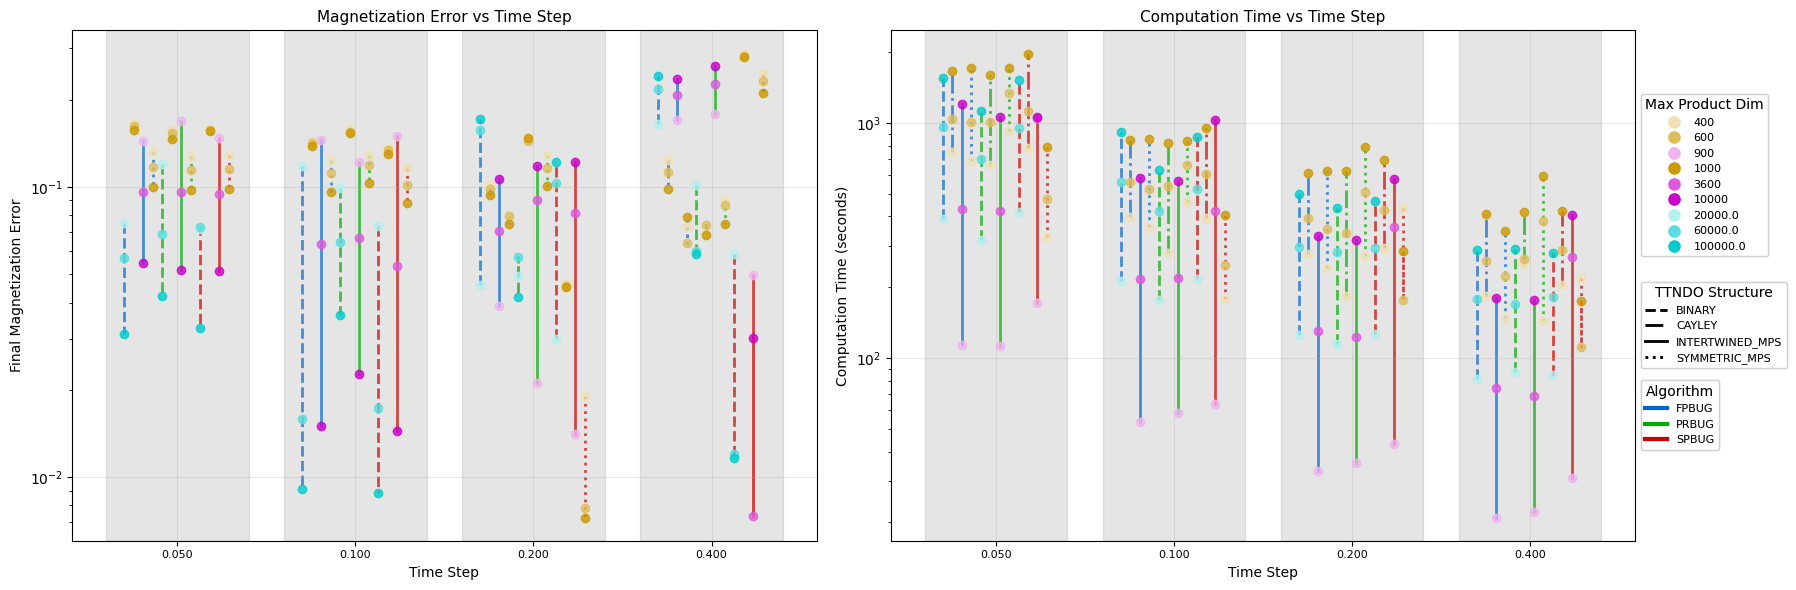

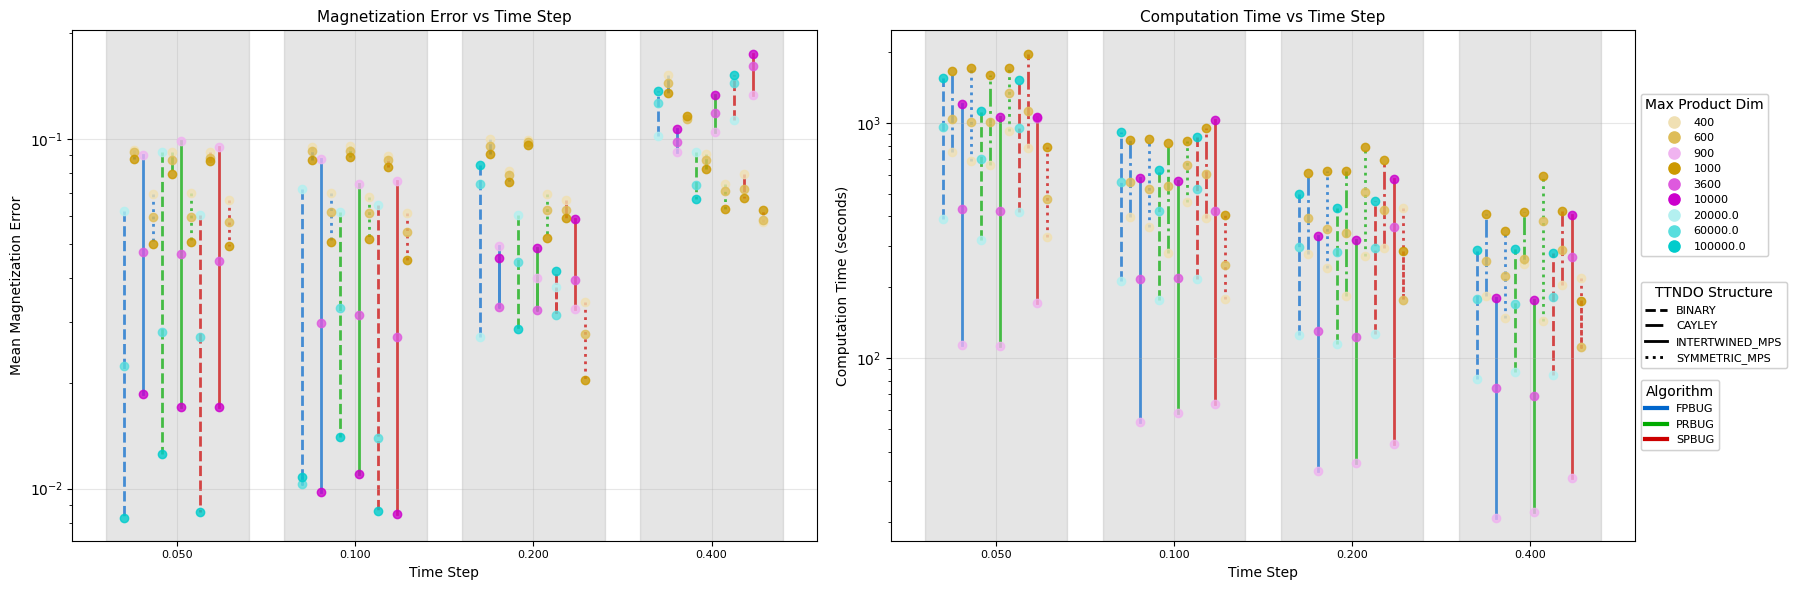

In [10]:
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.MAGNETIZATION,
                plot_mode=PlotMode.FINAL,
                figsize = (20, 6))
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.MAGNETIZATION,
                plot_mode=PlotMode.MEAN,
                figsize = (20, 6))

📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}


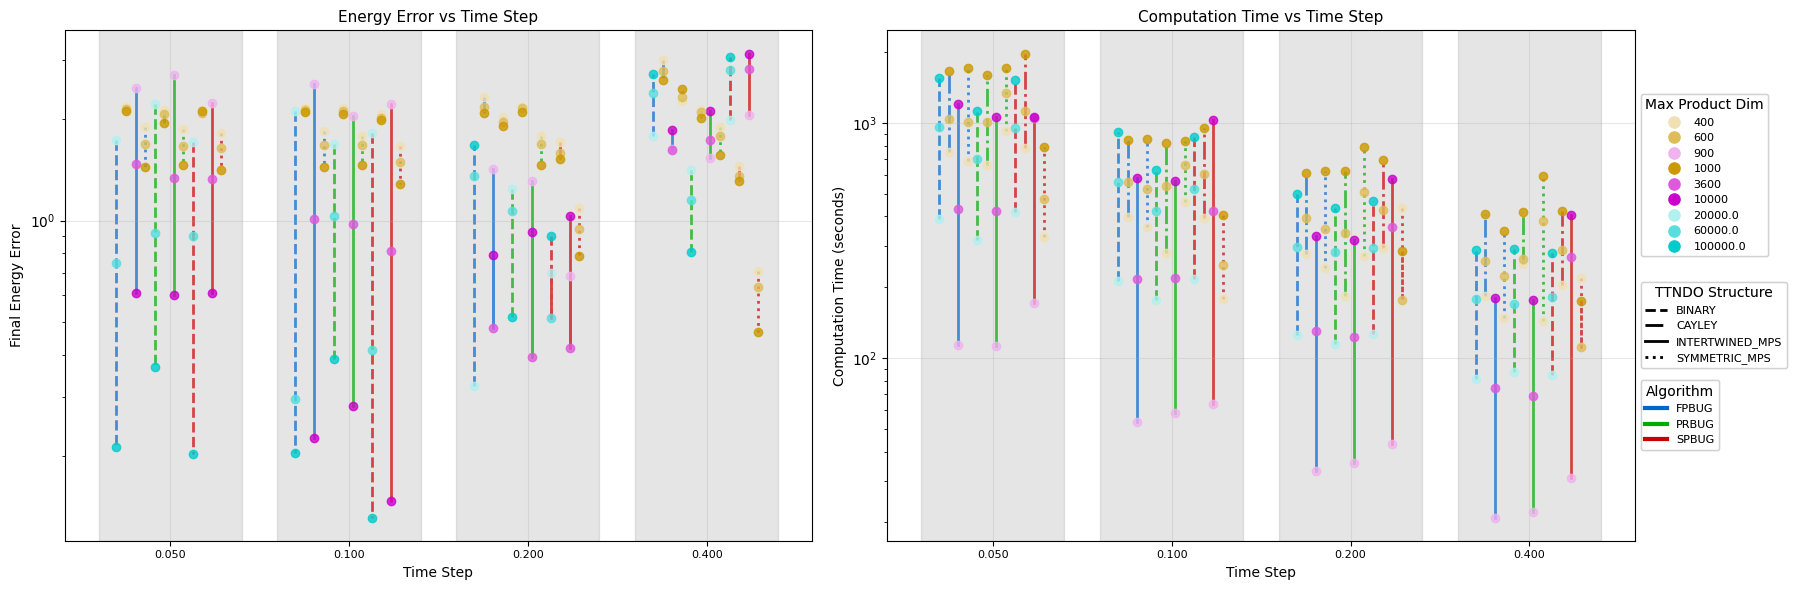

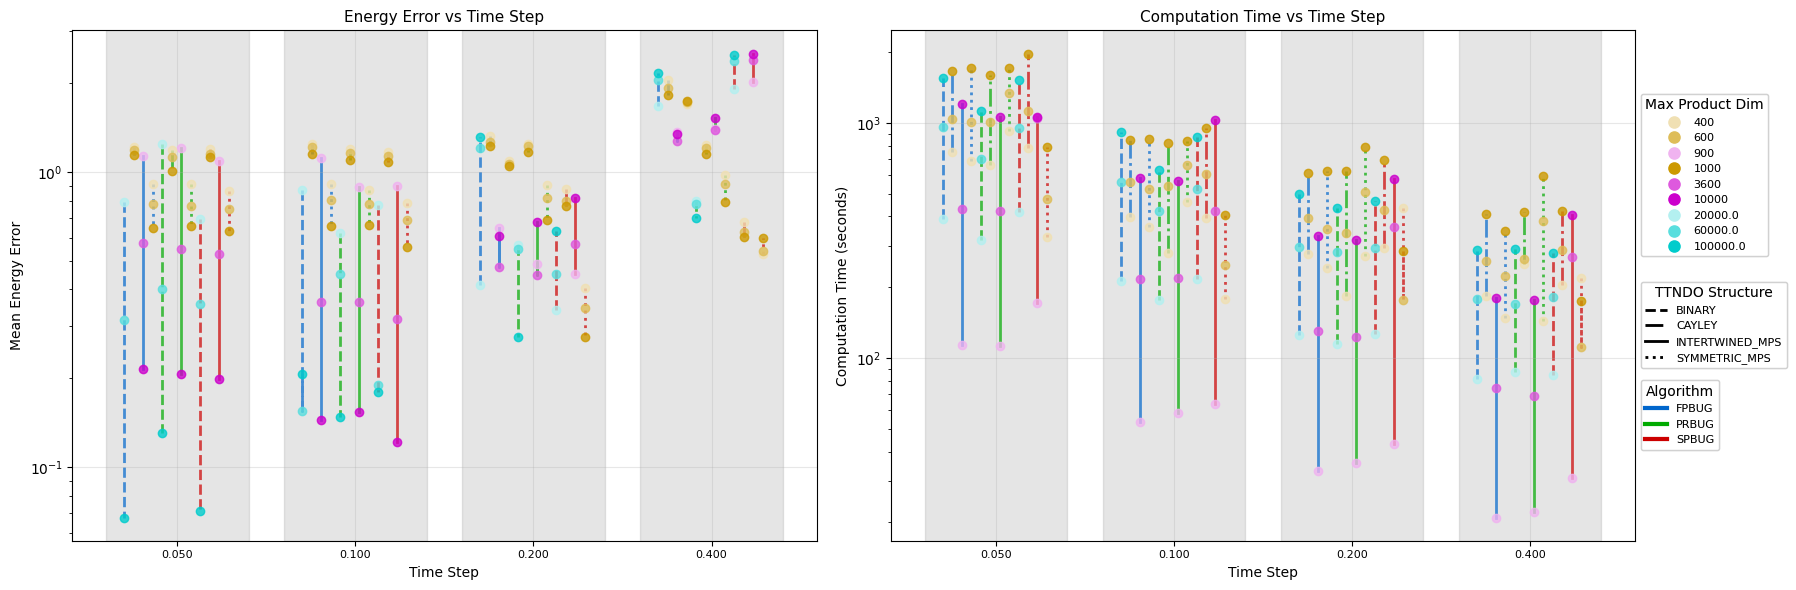

In [11]:
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.ENERGY,
                plot_mode=PlotMode.FINAL,
                figsize = (20, 6))
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.ENERGY,
                plot_mode=PlotMode.MEAN,
                figsize = (20, 6))

📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}
📊 Found 144 results matching criteria: {'experiment_label': 'benchmark'}


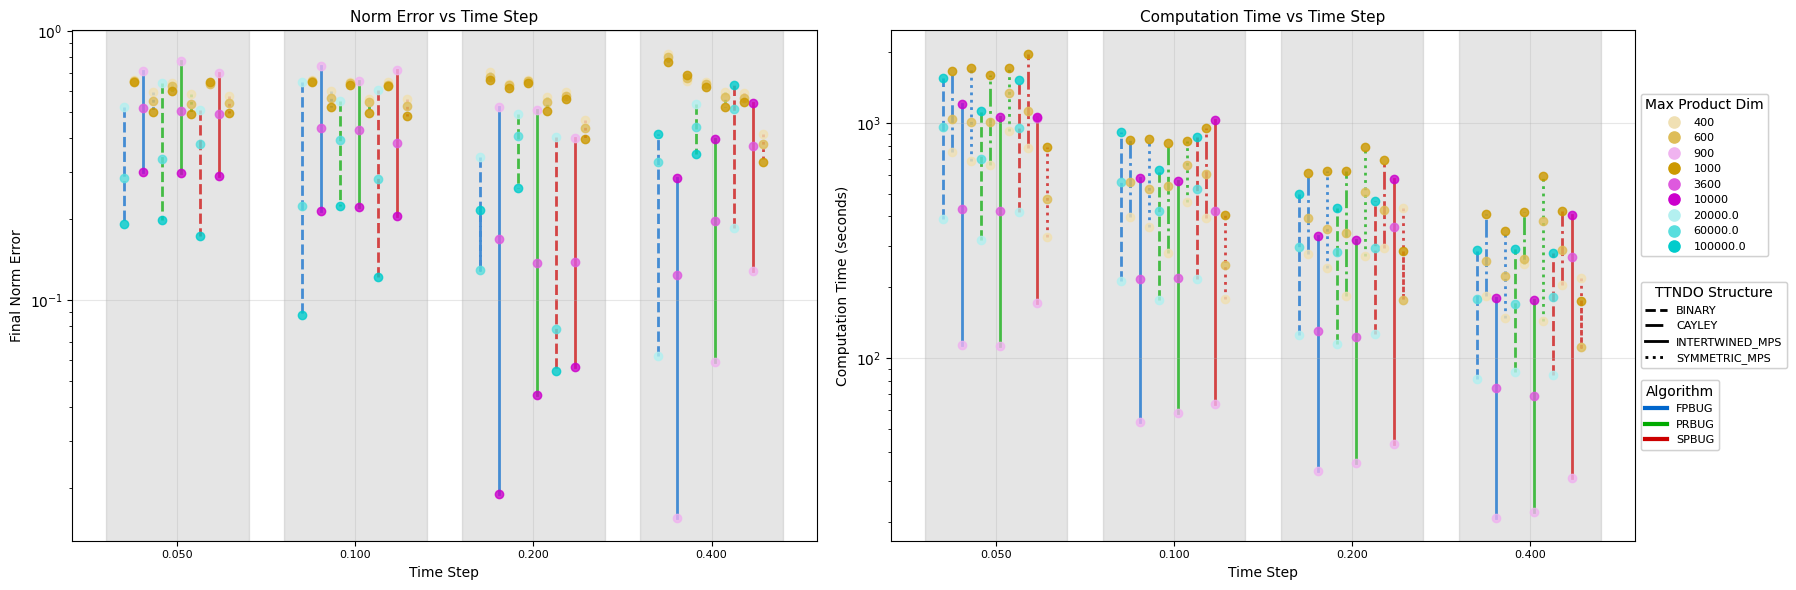

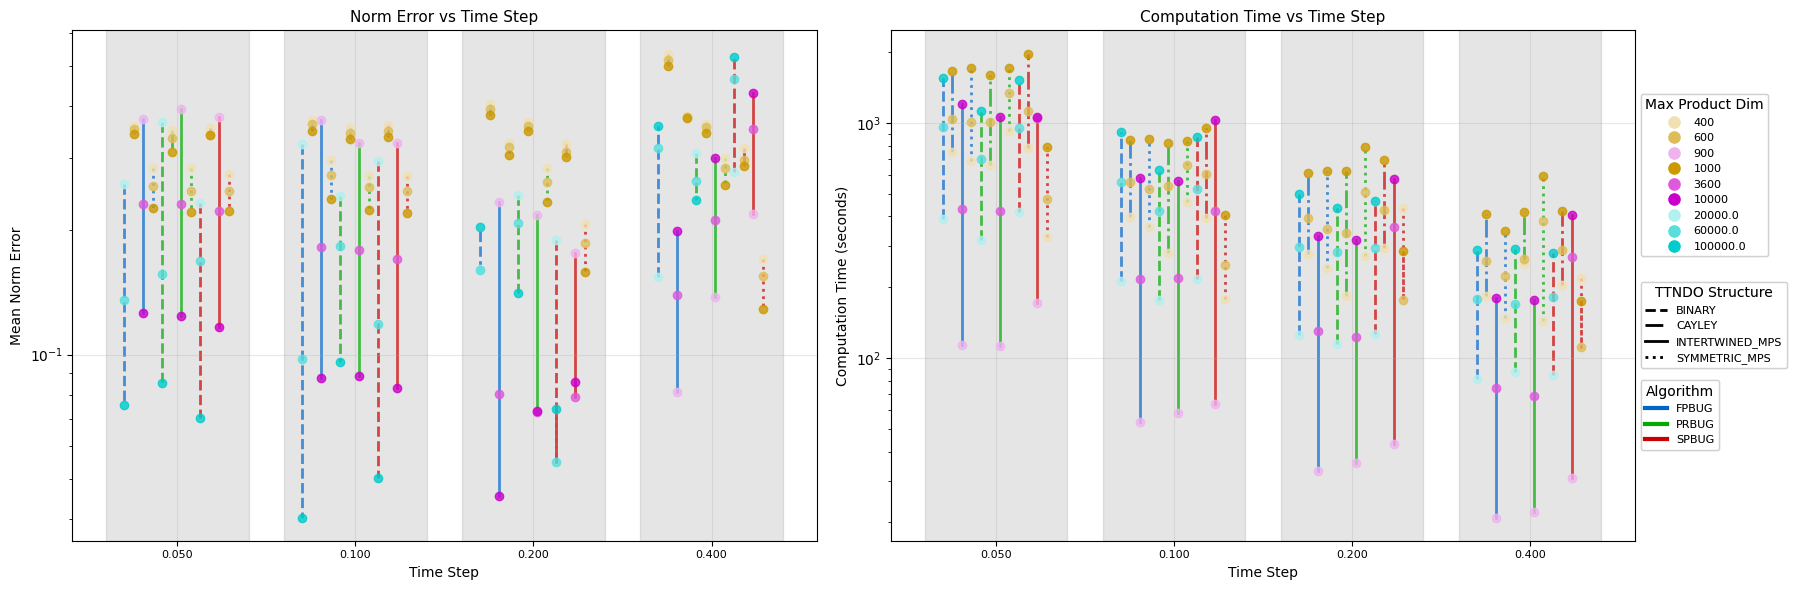

In [12]:
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.NORM,
                plot_mode=PlotMode.FINAL,
                figsize = (20, 6))
plot_benchmark_1(filter_criteria={'experiment_label': 'benchmark'},
                data_type=DataType.NORM,
                plot_mode=PlotMode.MEAN,
                figsize = (20, 6))

# **Benchmark 2**

In this section we try to compare different truncation modes available on Binary tree. 
Unlike Benchmark 1, which compared algorithms at fixed truncation parameters, this benchmark explores how different **truncation strategies** affect computational efficiency and accuracy.


## **Truncation schemes** :


### RECURSIVE_DOWNWARD
- **Strategy**: Recursively truncates bonds from root to leaves using SVD
- **Dimension Control**: Uses `max_bond_dim` (ignores `max_product_dim`)
- **Computational Pattern**: Processes nodes hierarchically, children after parents

### RECURSIVE_GREEDY 
- **Strategy**: Recursively truncates all bonds followed by greedy optimization
- **Dimension Control**: Uses `max_product_dim` (ignores `max_bond_dim`)
- **Computational Pattern**: Greedy optimization after initial truncation

### SWEEPING_ONWARD
- **Strategy**: Sweeps through the network, truncating one bond at a time using SVD
- **Dimension Control**: Uses `max_bond_dim` (ignores `max_product_dim`)
- **Computational Pattern**: Sequential processing along predefined path

### SWEEPING_GREEDY
- **Strategy**: Sweeps through network with greedy optimization at each step
- **Dimension Control**: Uses `max_product_dim` (ignores `max_bond_dim`)
- **Computational Pattern**: Greedy optimization during sweep

## What This Benchmark Tests

1. How do different truncation modes balance computational cost with simulation accuracy?
2. Which truncation modes work best with PRBUG vs FPBUG algorithms?
3.  How sensitive are results to `max_bond_dim` vs `max_product_dim` choices?


In [ ]:
from math import e
from pytreenet.core.truncation import TruncationMode

# length: Number of spins in the chain
length = 10
# ext_magn: External magnetic field strength in z-direction
ext_magn = 0.5
# coupling: Nearest-neighbor coupling strength for XX interactions
coupling = 1.0
# relaxation_rate: Local amplitude damping (relaxation) rate
relaxation_rate = 0.1
# dephasing_rate: Local dephasing rate
dephasing_rate = 0.1
# Time parameters
final_time = 4
time_step = 0.2
evaluation_time = 2
# Initialize bond dimension
init_bond_dim = 4
# Local evolution algorithms
time_evo_modes = [TimeEvoMode(TimeEvoMethod.RK45, {'atol': 1e-6, 'rtol': 1e-6})]
# Time evolution algorithms to test

def generate_parameters_2(experiment_label: str,
                                 ttn_structure: TTNStructure,
                                 depth: Optional[int],
                                 max_bond_dim_list: int,
                                 max_product_dim_list: int) -> list:
    """
    Generate complete parameter combinations for testing PRBUG and FPBUG with different truncation modes.
    Uses the new TruncationTimeEvolutionParameters dataclass that inherits from TimeEvolutionParameters.

    Args:
        experiment_label: Label for the experiment (same for all combinations)
        ttn_structure: Specific TTN structure
        depth: Specific depth value
        max_bond_dim: Maximum bond dimension for SVD truncation
        max_product_dim: Maximum product dimension for SVD truncation
        evaluation_time: Time between evaluations
        final_time: Final simulation time

    Returns:
        list: Complete parameter combinations ready for simulation
    """
    
    # Handle depth validation
    if ttn_structure == TTNStructure.SYMMETRIC_MPS and (depth != 0 or depth is None):
        warn("Invalid depth for Symmetric MPS, setting depth to 0")
        depth = 0
    elif ttn_structure == TTNStructure.INTERTWINED_MPS and (depth != 0 or depth is None):
        warn("Invalid depth for Intertwined MPS, setting depth to 0")
        depth = 0
    elif depth is None and ttn_structure not in [TTNStructure.INTERTWINED_MPS, TTNStructure.SYMMETRIC_MPS]:
        depth = max(1, math.ceil(math.log2(length)))
        print(f"Depth not specified, using maximum depth: {depth}")

    # Default time evolution mode
    time_evo_mode = TimeEvoMode(TimeEvoMethod.RK45, {'atol': 1e-6, 'rtol': 1e-6})

    # Algorithms to test (PRBUG and FPBUG only)
    truncation_evo_algs = [TimeEvoAlg.PRBUG, 
                           TimeEvoAlg.FPBUG]
    
    # All truncation modes
    truncation_modes = [
        TruncationMode.RECURSIVE_DOWNWARD,
        TruncationMode.RECURSIVE_GREEDY,
        TruncationMode.SWEEPING_ONWARD,
        TruncationMode.SWEEPING_GREEDY
    ]

    # Generate parameter combinations
    complete_params_list = []
    for evo_alg in truncation_evo_algs:
        for truncation_mode in truncation_modes:
            sim_params = SimulationParameters(experiment_label,  # Use same label for all
                                ttn_structure,
                                length,
                                coupling,
                                ext_magn,
                                relaxation_rate,
                                dephasing_rate,
                                init_bond_dim,
                                depth)
            # Configure SVD parameters based on truncation mode
            if truncation_mode in [TruncationMode.SWEEPING_GREEDY, TruncationMode.RECURSIVE_GREEDY]:
                # For greedy truncations: max_bond_dim=inf, max_product_dim=from_input
                configured_max_bond_dim = np.inf
                for max_product_dim in max_product_dim_list:
                    trunc_time_evo_params = TimeEvolutionParameters(time_evo_mode,
                                                evo_alg,
                                                time_step,
                                                evaluation_time,
                                                final_time,
                                                truncation_mode,
                                                max_bond_dim=configured_max_bond_dim,
                                                max_product_dim=max_product_dim,
                                                rel_svalue=1e-6,
                                                renorm=False,
                                                sum_trunc=True,
                                                sum_renorm=False)

                    complete_params_list.append((sim_params, trunc_time_evo_params))
            else:  # SWEEPING_ONWARD and RECURSIVE_DOWNWARD
                # For SVD truncations: max_bond_dim=from_input, max_product_dim=inf
                configured_max_product_dim = np.inf
                for max_bond_dim in max_bond_dim_list:
                    trunc_time_evo_params = TimeEvolutionParameters(time_evo_mode,
                                                evo_alg,
                                                time_step,
                                                evaluation_time,
                                                final_time,
                                                truncation_mode,
                                                max_bond_dim=max_bond_dim,
                                                max_product_dim=configured_max_product_dim,
                                                rel_svalue=1e-6,
                                                renorm=False,
                                                sum_trunc=True,
                                                sum_renorm=False)

                    complete_params_list.append((sim_params, trunc_time_evo_params))

    return complete_params_list

def plot_benchmark_2(filter_criteria,
                               plot_mode: PlotMode = PlotMode.FINAL,
                               save_path=None, 
                               figsize=(14, 10)):
    """
    Create magnetization error vs CPU time plot for truncation analysis.
    
    Each dot represents a simulation result. Simulations with the same parameters 
    except max_bond_dim or max_product_dim are connected with lines:
    - Dashed lines for greedy truncation modes (RECURSIVE_GREEDY, SWEEPING_GREEDY)
    - Solid lines for sweeping truncation modes (RECURSIVE_DOWNWARD, SWEEPING_ONWARD)
    - Different colors for different time_evo_algorithms
    - Different color schemes for max_product_dim (blue tones) and max_bond_dim (red tones)
    - Largest values are darkest, smallest values are palest
    
    Args:
        filter_criteria: Dict to filter results
        plot_mode: PlotMode enum specifying how to compute error metrics
        save_path: Optional path to save the plot
        figsize: Figure size (width, height)
    """
    groups = _load_and_process_benchmark_data(filter_criteria, plot_mode)
    
    if groups is None:
        return None

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Color schemes for algorithms (main distinction)
    algorithm_colors = {
        'prbug': '#00AA00',   # Green
        'fpbug': '#0066CC',   # Blue  
        'spbug': '#CC0000',   # Red
    }
    
    # Line styles for truncation modes
    truncation_linestyles = {
        'recursive_greedy': '--',     # Dashed for greedy
        'sweeping_greedy': '--',      # Dashed for greedy
        'recursive_downward': '-',    # Solid for sweeping
        'sweeping_onward': '-'        # Solid for sweeping
    }
    
    # Collect all unique dimensions and separate by type
    all_max_bond_dims = set()
    all_max_product_dims = set()
    all_truncation_modes = set()
    
    for (algorithm, structure), sims in groups.items():
        for sim in sims:
            bond_dim = sim['params'].get('max_bond_dim', float('inf'))
            product_dim = sim['params'].get('max_product_dim', float('inf'))
            
            if bond_dim != float('inf'):
                all_max_bond_dims.add(bond_dim)
            if product_dim != float('inf'):
                all_max_product_dims.add(product_dim)
                
            all_truncation_modes.add(sim['params'].get('truncation_mode', 'none'))
    
    # Create separate color schemes for bond dims and product dims
    dimension_colors = {}
    
    # Bond dimensions: Red color scheme (pale to dark red)
    sorted_bond_dims = sorted(all_max_bond_dims)
    if sorted_bond_dims:
        for i, dim in enumerate(sorted_bond_dims):
            if len(sorted_bond_dims) == 1:
                intensity = 0.7
            else:
                intensity = 0.3 + 0.6 * (i / (len(sorted_bond_dims) - 1))
            dimension_colors[dim] = (intensity, 0.1, 0.1) 
    
    # Product dimensions: Blue color scheme (pale to dark blue)
    sorted_product_dims = sorted(all_max_product_dims)
    if sorted_product_dims:
        for i, dim in enumerate(sorted_product_dims):
            if len(sorted_product_dims) == 1:
                intensity = 0.7
            else:
                intensity = 0.3 + 0.6 * (i / (len(sorted_product_dims) - 1))
            dimension_colors[dim] = (0.1, 0.1, intensity)
    
    dimension_colors[float('inf')] = (0.0, 0.0, 0.0)
    
    plotted_algorithms = set()
    plotted_truncation_modes = set()
    plotted_bond_dims = set()
    plotted_product_dims = set()
    
    # Group simulations by (algorithm, structure, truncation_mode) for line connections
    connection_groups = defaultdict(list)
    
    for (algorithm, structure), sims in groups.items():
        for sim in sims:
            truncation_mode = sim['params'].get('truncation_mode', 'none')
            group_key = (algorithm, structure, truncation_mode,
                        sim['params'].get('time_step_size', 0),
                        sim['params'].get('evaluation_time', 0),
                        sim['params'].get('final_time', 0))
            connection_groups[group_key].append(sim)
    
    # Plot each connection group
    for group_key, group_sims in connection_groups.items():
        algorithm, structure, truncation_mode = group_key[:3]
        
        if not group_sims:
            continue
        bond_dims = [sim['params'].get('max_bond_dim', float('inf')) for sim in group_sims]
        product_dims = [sim['params'].get('max_product_dim', float('inf')) for sim in group_sims]
        bond_dims_vary = len(set(bond_dims)) > 1 and not all(d == float('inf') for d in bond_dims)
        product_dims_vary = len(set(product_dims)) > 1 and not all(d == float('inf') for d in product_dims)
        
        if bond_dims_vary:
            # Sort by bond dimension
            group_sims_sorted = sorted(group_sims, key=lambda x: x['params'].get('max_bond_dim', float('inf')))
            varying_dims = [sim['params'].get('max_bond_dim', float('inf')) for sim in group_sims_sorted]
            dim_type = 'bond'
        elif product_dims_vary:
            # Sort by product dimension  
            group_sims_sorted = sorted(group_sims, key=lambda x: x['params'].get('max_product_dim', float('inf')))
            varying_dims = [sim['params'].get('max_product_dim', float('inf')) for sim in group_sims_sorted]
            dim_type = 'product'
        else:
            # No varying dimension, just plot individual points
            group_sims_sorted = group_sims
            bond_dim = group_sims[0]['params'].get('max_bond_dim', float('inf'))
            product_dim = group_sims[0]['params'].get('max_product_dim', float('inf'))
            
            # Determine which dimension is being used (not infinite)
            if bond_dim != float('inf'):
                varying_dims = [bond_dim] * len(group_sims)
                dim_type = 'bond'
            elif product_dim != float('inf'):
                varying_dims = [product_dim] * len(group_sims)
                dim_type = 'product'
            else:
                varying_dims = [float('inf')] * len(group_sims)
                dim_type = 'unknown'
        
        # Get plotting parameters
        base_color = algorithm_colors.get(algorithm.lower(), '#000000')
        linestyle = truncation_linestyles.get(truncation_mode.lower(), '-')
        
        # Extract data for plotting
        cpu_times = [sim['cpu_time'] for sim in group_sims_sorted]
        mag_errors = [sim['mag_error'] for sim in group_sims_sorted]
        
        # Plot individual points with dimension-specific colors
        for cpu_time, mag_error, dim in zip(cpu_times, mag_errors, varying_dims):
            dim_color = dimension_colors.get(dim, (0.5, 0.5, 0.5))
            
            # Plot point with algorithm color border and dimension color fill
            ax.scatter(cpu_time, mag_error, 
                      c=[dim_color], 
                      edgecolors=base_color, 
                      marker='o', 
                      s=80, 
                      linewidth=2,
                      alpha=0.8)
            
            # Track plotted dimensions by type
            if dim_type == 'bond':
                plotted_bond_dims.add(dim)
            elif dim_type == 'product':
                plotted_product_dims.add(dim)
        
        # Connect points with line if more than one point
        if len(cpu_times) > 1:
            ax.plot(cpu_times, mag_errors, 
                   color=base_color, 
                   linestyle=linestyle, 
                   linewidth=2, 
                   alpha=0.6,
                   zorder=0)
        
        plotted_algorithms.add(algorithm)
        plotted_truncation_modes.add(truncation_mode)
    
    # Create legends
    # 1. Algorithm legend (colors)
    algorithm_handles = [plt.Line2D([0], [0], color=algorithm_colors.get(a.lower(), '#000000'),
                                   linestyle='-', linewidth=3, label=a.upper())
                        for a in sorted(plotted_algorithms)]
    
    # 2. Truncation mode legend (line styles)
    truncation_handles = []
    for mode in sorted(plotted_truncation_modes):
        if mode != 'none':
            linestyle = truncation_linestyles.get(mode.lower(), '-')
            label = mode.replace('_', ' ').title()
            truncation_handles.append(plt.Line2D([0], [0], color='black', 
                                                linestyle=linestyle, linewidth=2, label=label))
    
    # 3. Bond dimension legend (red colors)
    bond_dim_handles = []
    for dim in sorted(plotted_bond_dims):
        if dim != float('inf'):
            color = dimension_colors.get(dim, (0.5, 0.5, 0.5))
            label = f'Bond: {int(dim)}'
            bond_dim_handles.append(plt.Line2D([0], [0], color='black', 
                                              markerfacecolor=color,
                                              marker='o', 
                                              linestyle='', 
                                              markersize=8, 
                                              markeredgewidth=1,
                                              label=label))
    
    # 4. Product dimension legend (blue colors)
    product_dim_handles = []
    for dim in sorted(plotted_product_dims):
        if dim != float('inf'):
            color = dimension_colors.get(dim, (0.5, 0.5, 0.5))
            label = f'Product: {int(dim)}'
            product_dim_handles.append(plt.Line2D([0], [0], color='black', 
                                                  markerfacecolor=color,
                                                  marker='o', 
                                                  linestyle='', 
                                                  markersize=8, 
                                                  markeredgewidth=1,
                                                  label=label))
    
    # Adjust layout for legends
    plt.tight_layout()
    plt.subplots_adjust(right=0.70)  # Make space for legends
    
    # Create legends outside the plot
    legend_y_positions = [0.85, 0.70, 0.50, 0.3]
    legends = []
    
    if algorithm_handles:
        legend1 = fig.legend(handles=algorithm_handles, title='Algorithm',
                            loc='center left', bbox_to_anchor=(0.72, legend_y_positions[0]), fontsize=9)
        fig.add_artist(legend1)
        legends.append(legend1)
    
    if truncation_handles:
        legend2 = fig.legend(handles=truncation_handles, title='Truncation Mode',
                            loc='center left', bbox_to_anchor=(0.72, legend_y_positions[1]), fontsize=9)
        fig.add_artist(legend2)
        legends.append(legend2)
    
    if bond_dim_handles:
        legend3 = fig.legend(handles=bond_dim_handles, title='Max Bond Dim (Red)',
                            loc='center left', bbox_to_anchor=(0.72, legend_y_positions[2]), fontsize=9)
        fig.add_artist(legend3)
        legends.append(legend3)
    
    if product_dim_handles:
        legend4 = fig.legend(handles=product_dim_handles, title='Max Product Dim (Blue)',
                            loc='center left', bbox_to_anchor=(0.72, legend_y_positions[3]), fontsize=9)
        fig.add_artist(legend4)
        legends.append(legend4)
    
    # Axis labels and scaling
    ax.set_xlabel('CPU Time (seconds)', fontsize=12)
    ax.set_ylabel(f'{plot_mode.value.title()} Magnetization Error', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    ax.set_xscale('log')  # Log scale for CPU time as well
    
    # Save plot if requested
    if save_path:
        fig.savefig(save_path, dpi=300, 
                   bbox_extra_artists=legends,
                   bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")

In [14]:
# Define parameter ranges for truncation analysis
max_bond_dim_values = [10, 15, 20 ,25]
max_product_dim_values = [10**3, 15**3, 20**3, 25**3]

# Generate parameters for Binary Tree structure with truncation mode analysis
parameters = generate_parameters_2(experiment_label="truncation_analysis",
                                   ttn_structure=TTNStructure.BINARY,
                                   depth=4,
                                   max_bond_dim_list=max_bond_dim_values,
                                   max_product_dim_list=max_product_dim_values)
# Execute the benchmark
run_benchmarks(parameters=parameters,
               benchmark_dir=benchmark_dir,
               ask_overwrite=False)

,Parameters Hash,Algorithm,TTNDO structure,Time Step,Max Bond Dim,Max Product Dim,Status,CPU_time
0,a4c5ea774982,prbug / RK45,binary,0.200,10,inf,skipped,12.62s
1,7f366c98f17d,prbug / RK45,binary,0.200,15,inf,skipped,19.51s
2,436f9fbda734,prbug / RK45,binary,0.200,20,inf,skipped,30.03s
3,1643df7189cf,prbug / RK45,binary,0.200,25,inf,skipped,41.94s
4,f2544d54ea3e,prbug / RK45,binary,0.200,inf,1000.0,skipped,12.04s
5,2bb36ccb4551,prbug / RK45,binary,0.200,inf,3375.0,skipped,22.20s
6,62ce4598ba75,prbug / RK45,binary,0.200,inf,8000.0,skipped,34.21s
7,7a4e3278aacc,prbug / RK45,binary,0.200,inf,15625.0,skipped,46.51s
8,649b33c389c0,prbug / RK45,binary,0.200,10,inf,skipped,12.66s
9,ea7d19015f54,prbug / RK45,binary,0.200,15,inf,skipped,19.89s


## Plot results

📊 Found 32 results matching criteria: {'experiment_label': 'truncation_analysis'}
📊 Found 32 results matching criteria: {'experiment_label': 'truncation_analysis'}
📊 Found 32 results matching criteria: {'experiment_label': 'truncation_analysis'}


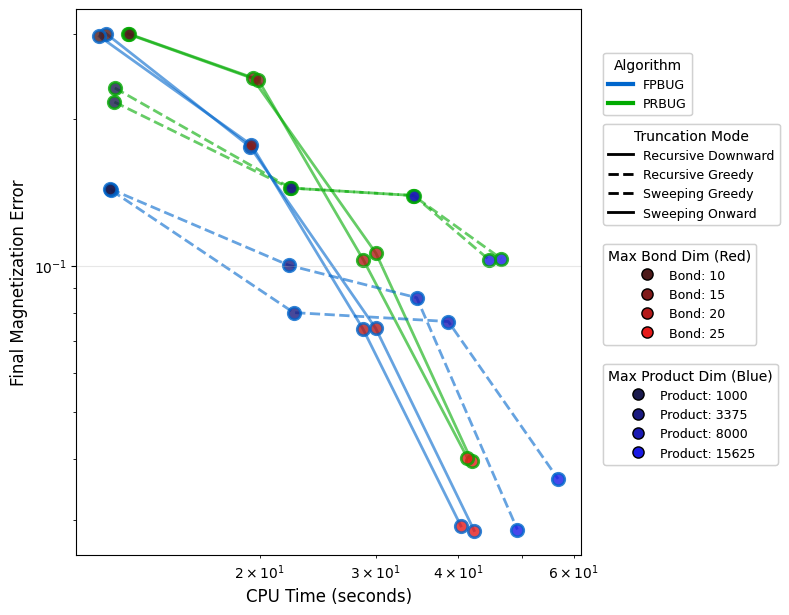

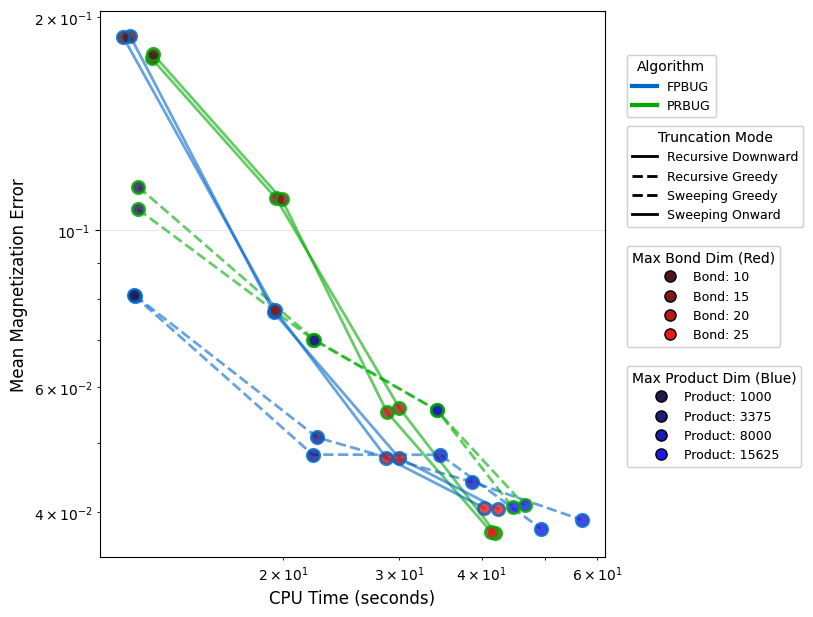

In [17]:
# Plot magnetization error vs CPU time for truncation analysis
plot_benchmark_2(filter_criteria={'experiment_label': 'truncation_analysis'},
                 plot_mode=PlotMode.FINAL,
                 figsize=(8, 6))
plot_benchmark_2(filter_criteria={'experiment_label': 'truncation_analysis'},
                 plot_mode=PlotMode.MEAN,
                 figsize=(8, 6))